In [1]:
import hetmech.degree_weight
from hetmech.degree_weight import dwpc
from hetmech.hetmat import HetMat
import numpy as np
import pandas as pd
from scipy import sparse
from hetmech.matrix import metaedge_to_adjacency_matrix
import hetmech.degree_group
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
%matplotlib inline

In [2]:
hetmat = HetMat('../data/hetionet-v1.0.hetmat/')

In [3]:
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')

## View distributions of single path DWPC across permutations

I think a hurdle model would be useful here, where we have a simple probability $p$ that a permutation is nonzero, and a distribution of nonzero values. $p$ could be a useful bit of information for scaling DWPC values between metapaths.

I think that the inverse gamma distribution is probably what we want to use for the distribution of DWPC on permutations given that the DWPC value is greater than zero.

In [4]:
def make_all_plots(metapath):
    x = np.linspace(0, 10, num=1000)
    palette = sns.color_palette('Set1', n_colors=20, desat=.75)
    
    scaler = hetmech.degree_weight.dwpc(hetmat, metapath, damping=0.5, dense_threshold=1)[2].mean()

    source_deg, target_deg = hetmech.degree_group.metapath_to_degree_dicts(hetmat, metapath)
    chosen_source_degree = np.random.choice(list(source_deg.keys()), size=20)
    chosen_target_degree = np.random.choice(list(target_deg.keys()), size=20)

    dwpc_dict = dict()
    for name, permat in hetmat.permutations.items():
        _, _, matrix = dwpc(permat, metapath, damping=0.5, dense_threshold=1)
        matrix = np.arcsinh(matrix / scaler)
        dwpc_dict[name] = matrix

    # Get acutal distribution
    _, _, dwpc_matrix = dwpc(hetmat, metapath, dense_threshold=1)
    dwpc_matrix = np.arcsinh(dwpc_matrix / scaler).toarray()
    dwpc_values = dwpc_matrix.flatten()

    true_dist = dict()
    degree_to_dgp = dict()
    for i in range(3):
        row_inds = source_deg[chosen_source_degree[i]]
        col_inds = target_deg[chosen_target_degree[i]]
        
        mat = dwpc_matrix[row_inds, :]
        mat = mat[:, col_inds]
        true_dist[((chosen_source_degree[i], chosen_target_degree[i]))] = mat.flatten()
        
        all_dgp = np.array([])
        for matrix in dwpc_dict.values():
            matrix = matrix[row_inds, :]
            matrix = matrix[:, col_inds]
            matrix = matrix.toarray().flatten()

            all_dgp = np.concatenate((all_dgp, matrix))
        degree_to_dgp[(chosen_source_degree[i], chosen_target_degree[i])] = all_dgp
    
    # Estimate the overall distribution
    all_dwpc = np.array([])
    for matrix in dwpc_dict.values():
        all_dwpc = np.concatenate((all_dwpc, matrix.toarray().flatten()))
    
    i = 0
    plt.figure(figsize=(16, 9))
    plt.title(f"Distribution of DGP on {metapath}")
    for degrees, dgp in degree_to_dgp.items():
        plt.hist(dgp, density=True, label=str(degrees), alpha=0.3);
        plt.vlines(true_dist[degrees], 0, 1, label=str(degrees), colors=palette[i])
        i += 1
    plt.xlim((0, 6))
    plt.legend(title='source, target degree', prop=fontP);

    i = 0
    plt.figure(figsize=(16, 9))
    plt.title(f"Distribution of DGP on {metapath}")
    for degrees, dgp in degree_to_dgp.items():
        sns.kdeplot(dgp, label=str(degrees), alpha=0.7, linewidth=4, bw=0.25, color=palette[i]);
        plt.vlines(true_dist[degrees], 0, 1, label=str(degrees), colors=palette[i])
        i += 1
    plt.xlim((0, 6))
    plt.legend(title='source, target degree', prop=fontP);

    i = 0
    plt.figure(figsize=(16, 9))
    plt.title(f"Distribution of nonzero DGP on {metapath}")
    for degrees, dgp in degree_to_dgp.items():
        if len(dgp[dgp != 0]) == 0:
            continue
        a, b, c = scipy.stats.invgamma.fit(dgp[dgp != 0])
        d, e = scipy.stats.norm.fit(dgp[dgp != 0])
        plt.plot(x, scipy.stats.invgamma.pdf(x, a, b, c), color=palette[i], linestyle='-.', label=f'inv$\gamma$ {degrees}')
        plt.plot(x, scipy.stats.norm.pdf(x, d, e), color=palette[i], linestyle=':', label=f'norm {degrees}')
        plt.hist(dgp[dgp != 0], density=True, label=str(degrees), alpha=0.4, color=palette[i]);
        plt.vlines(true_dist[degrees], 0, 1, label=str(degrees), colors=palette[i])
        i += 1
    plt.xlim((0, 6))
    plt.legend(title='source, target degree', prop=fontP);

    i = 0
    plt.figure(figsize=(16, 9))
    plt.title(f"Distribution of nonzero DGP on {metapath}")
    for degrees, dgp in degree_to_dgp.items():
        if len(dgp[dgp != 0]) == 0:
            continue
        a, b, c = scipy.stats.invgamma.fit(dgp[dgp != 0])
        d, e = scipy.stats.norm.fit(dgp[dgp != 0])
        plt.plot(x, scipy.stats.invgamma.pdf(x, a, b, c), color=palette[i], linestyle='-.', label=f'inv$\gamma$ {degrees}')
        plt.plot(x, scipy.stats.norm.pdf(x, d, e), color=palette[i], linestyle=':', label=f'norm {degrees}')
        sns.kdeplot(dgp[dgp != 0], label=str(degrees), alpha=0.7, linewidth=4, bw=0.3, color=palette[i], shade=True);
        plt.vlines(true_dist[degrees], 0, 1, label=str(degrees), colors=palette[i])
        i += 1
    plt.xlim((0, 6))
    plt.legend(title='source, target degree', prop=fontP);

/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


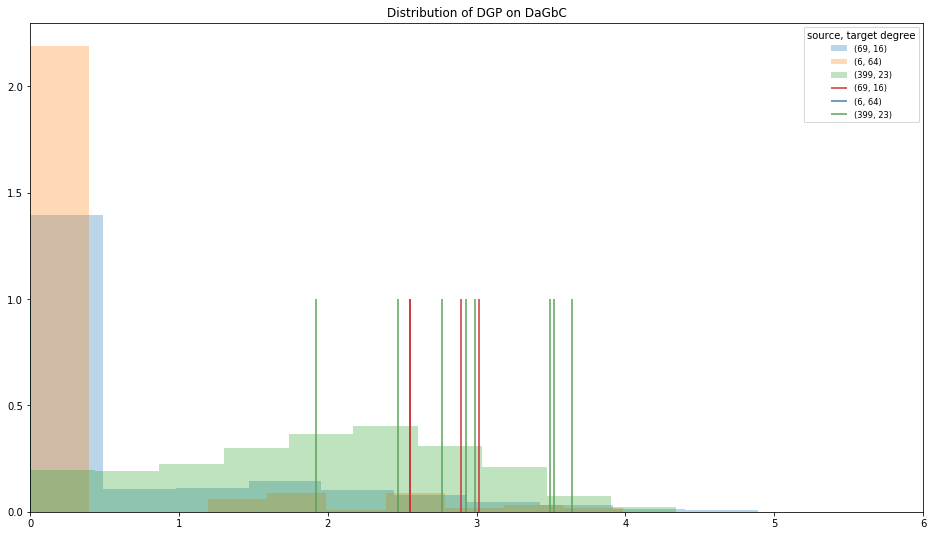

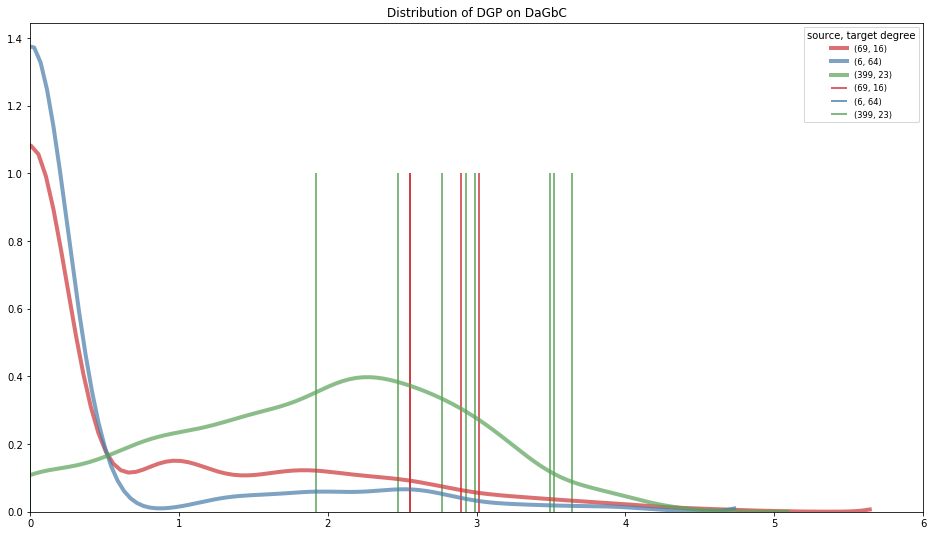

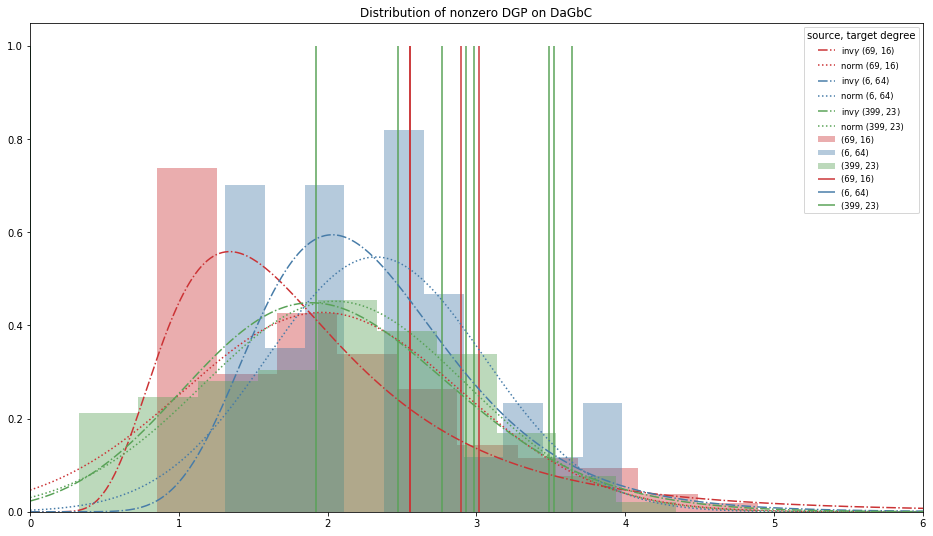

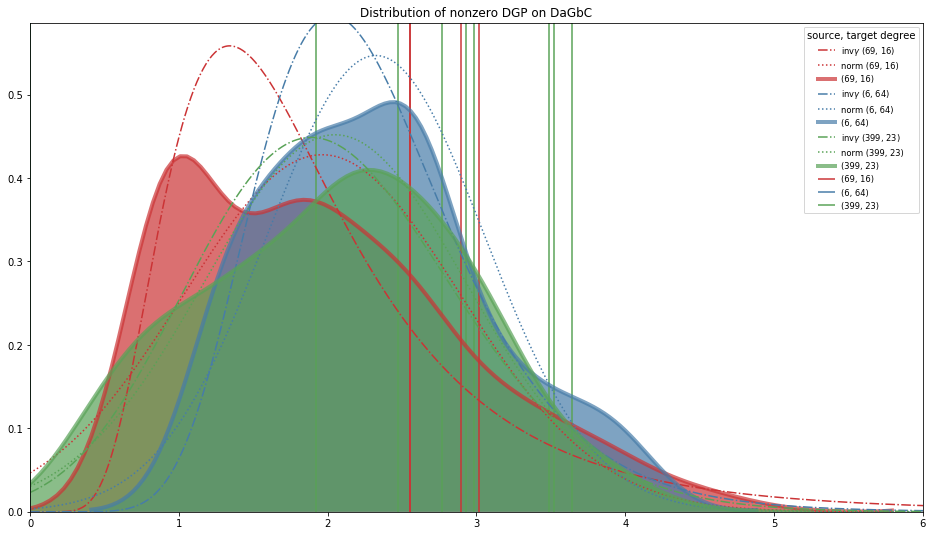

In [5]:
make_all_plots('DaGbC')

/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


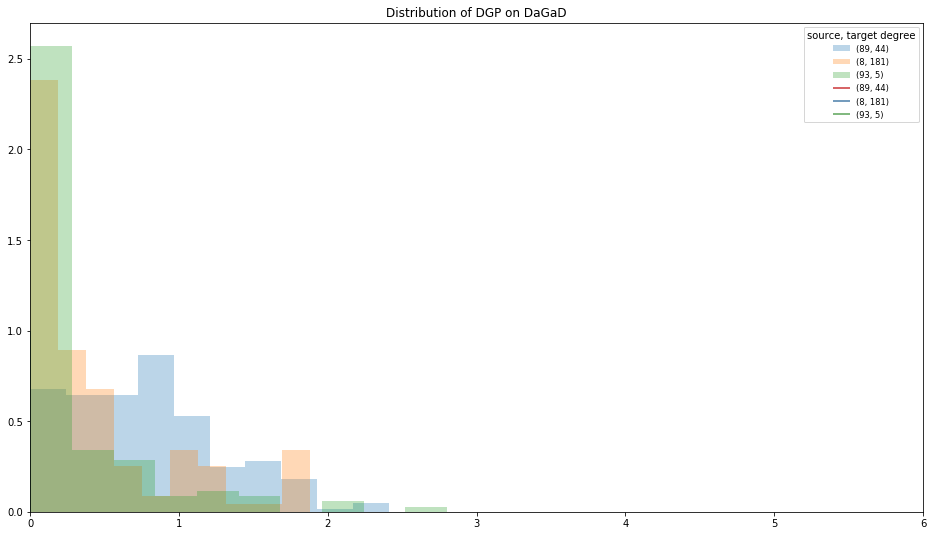

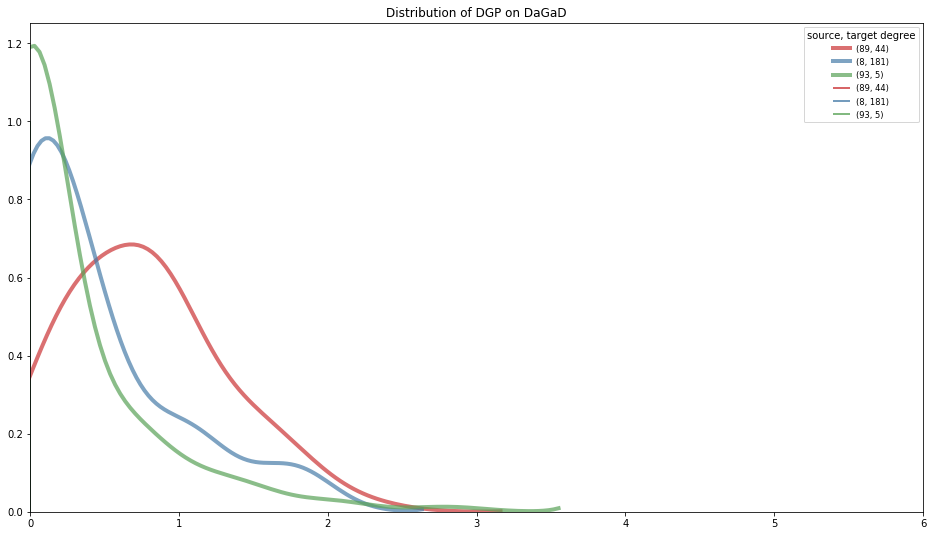

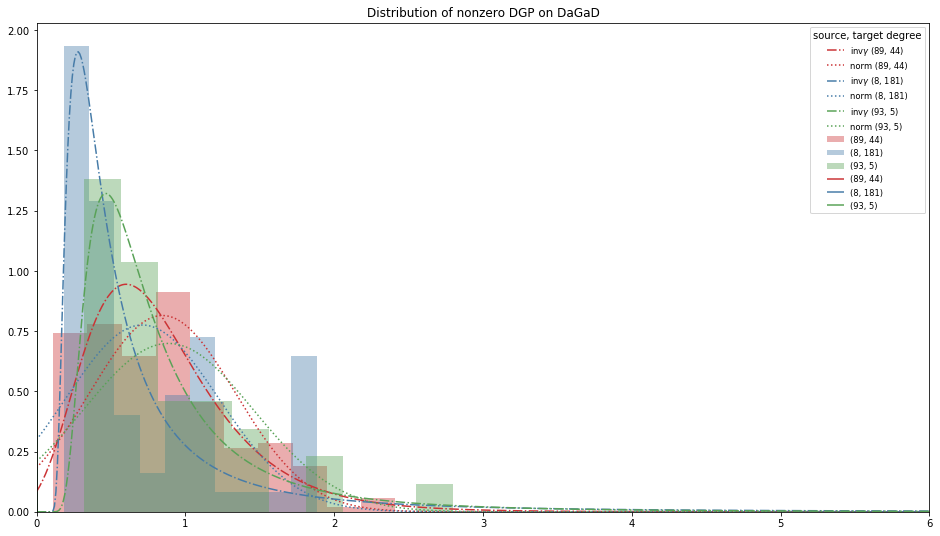

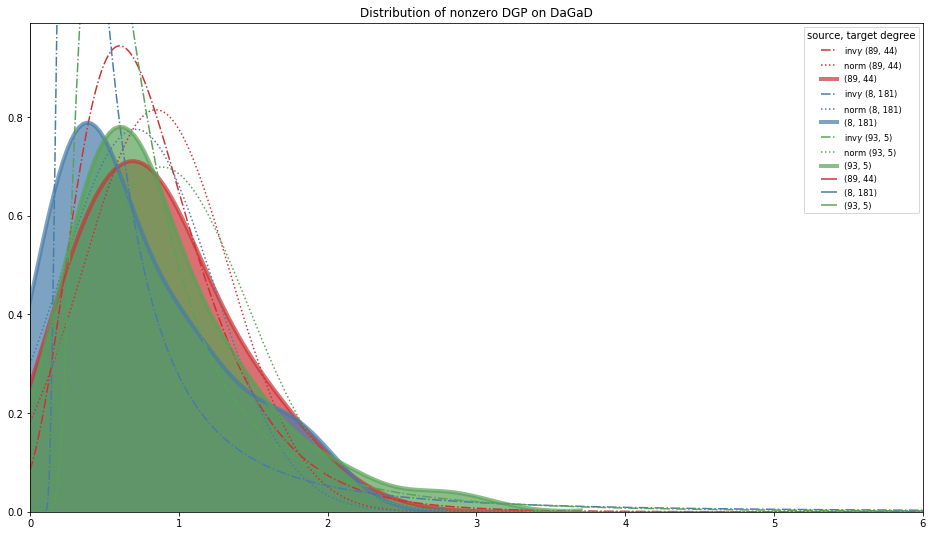

In [6]:
make_all_plots('DaGaD')

## Normal vs beta vs inverse gamma

Vertical black lines represent actual DWPC values from the unpermuted network.

In [7]:
metapath = 'CbGiGaD'

scaler = hetmech.degree_weight.dwpc(hetmat, metapath, damping=0.5, dense_threshold=1)[2].mean()

source_deg, target_deg = hetmech.degree_group.metapath_to_degree_dicts(hetmat, metapath)
chosen_source_degree = np.random.choice(list(source_deg.keys()), size=20)
chosen_target_degree = np.random.choice(list(target_deg.keys()), size=20)

dwpc_dict = dict()
for name, permat in hetmat.permutations.items():
    _, _, matrix = dwpc(permat, metapath, damping=0.5, dense_threshold=1)
    matrix = np.arcsinh(matrix / scaler)
    dwpc_dict[name] = matrix

# Get acutal distribution
_, _, dwpc_matrix = dwpc(hetmat, metapath, dense_threshold=1)
dwpc_matrix = np.arcsinh(dwpc_matrix / scaler).toarray()
dwpc_values = dwpc_matrix.flatten()

true_dist = dict()
degree_to_dgp = dict()
for i in range(20):
    row_inds = source_deg[chosen_source_degree[i]]
    col_inds = target_deg[chosen_target_degree[i]]

    mat = dwpc_matrix[row_inds, :]
    mat = mat[:, col_inds]
    true_dist[((chosen_source_degree[i], chosen_target_degree[i]))] = mat.flatten()

    all_dgp = np.array([])
    for matrix in dwpc_dict.values():
        matrix = matrix[row_inds, :]
        matrix = matrix[:, col_inds]
        matrix = matrix.toarray().flatten()

        all_dgp = np.concatenate((all_dgp, matrix))
    degree_to_dgp[(chosen_source_degree[i], chosen_target_degree[i])] = all_dgp

/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:437: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


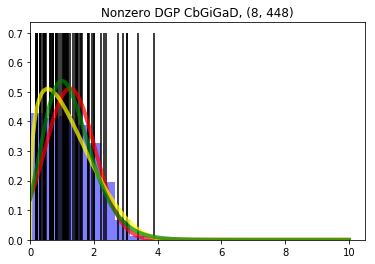

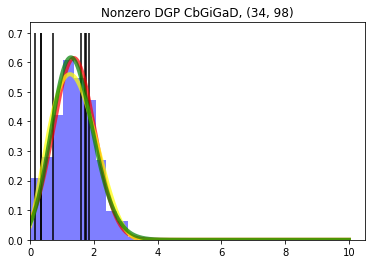

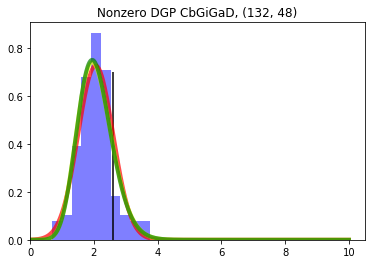

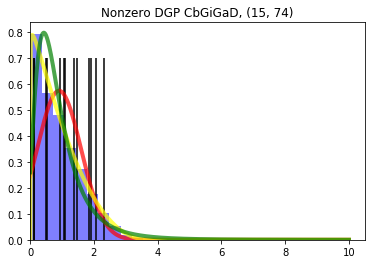

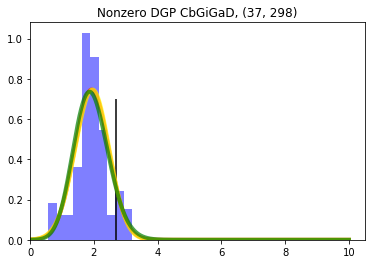

In [8]:
x = np.linspace(0, 10, 1000)

for i in range(5):
    key = list(degree_to_dgp.keys())[i]
    vals = degree_to_dgp[key]

    mu, sig = scipy.stats.norm.fit(vals[vals != 0])
    a, b, c, d = scipy.stats.beta.fit(vals[vals != 0])
    e, f, g = scipy.stats.invgamma.fit(vals[vals != 0])
    plt.figure()
    plt.hist(vals[vals != 0], density=True, color='blue', alpha=0.5)
    plt.plot(x, scipy.stats.norm.pdf(x, mu, sig), color='red', linewidth=4, alpha=0.7)
    plt.plot(x, scipy.stats.beta.pdf(x, a, b, c, d), color='yellow', linewidth=4, alpha=0.7)
    plt.plot(x, scipy.stats.invgamma.pdf(x, e, f, g), color='green', linewidth=4, alpha=0.7)
    plt.vlines(true_dist[key], 0, 0.7)
    plt.xlim((0, None))
    plt.title(f"Nonzero DGP {metapath}, {key}")